# Cooking ingredients recommendation
This notebook builds a recommendation system for cooking ingredients using. The end goal is to build a recommendation system that takes as input a list of existing ingredients and outputs a collection of ingredients that would go well with the existing ingredients. 

<b> Notebook contents </b>
0. load and clean data  
1. Preliminary analysis
2. Non-negative matrix factorizations
3. Word-embeddings
4. Neural network 
5. Association rule mining    
6. Latent Dirichlet Allocations
7. Future directions / To Do 

***NOTE:*** *This is project is in progress.*



In [1]:
import pandas as pd
import numpy as np
import re
import random
import ijson
import ast 
import csv
import statistics
from itertools import combinations


from sklearn.decomposition import NMF
from sklearn.decomposition import PCA
from collections import Counter 
 
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')

import os
import pickle
import h5py
import gensim
from gensim.models import Word2Vec
from gensim.models.nmf import Nmf
from gensim.corpora import Dictionary

from efficient_apriori import apriori

# 0. Load & clean data    

* data: <a href="https://www.kaggle.com/kaggle/recipe-ingredients-dataset/">recipe-ingredients dataset</a> from Kaggle. The dataset was part of a competition for predicting the cuisine type given ingredients list. 
* I chose this dataset because I wanted my recommender system to address questions like "How do I cook my chicken in Indian style? Korean style?  
* I used just the training data of this dataset. If one was interested in building a recommender system for ingredients without considering the cuisine, one could use both the training and testing set of the Kaggle dataset. One can also extend the dataset by combining with other sources of recipe data  
* For example, the "recipes" notebook uses a different dataset. Note that that particular dataset requires more involved text cleaning process than the kaggle dataset

<b> Contents </b>  
(a) Cleanup text  
(b) Remove "stop words"  
(c) Create documents that contain both the list of ingredients and cuisine type  

<b> (a) Cleanup text </b>  
* Cleanups performed
    * Remove parentheses and characters between parentheses. This removes quantity information. ex) " (2 oz. ) tomato sauce"
    * Convert all strings into lowercase letters  
    * Replace spaces with underscore _   
 
* Remaining issues with the data after cleanup step
    * Some ingredients contain brand names of the ingredients.  
    * Some ingredients contain non-alphabet characters. Many of them seem to come from brand names.   
    * Some ingredients contain cooking instructions. Example: "spinach, thawed and squeezed dry"  

In [2]:
# load data
file_name = 'data/recipe-ingredients-dataset/train.json'

with open(file_name, 'r') as f:
    objects = ijson.items(f, 'item')
    data = list(objects)

df = pd.DataFrame(data)

In [3]:
# Look at data to figure out what kind of text cleaning we need to do

ing_list = df['ingredients'].tolist()
cuisine_list = df['cuisine'].tolist()

if len(ing_list) == len(cuisine_list):
    ingredients = [ing_list[i] + [cuisine_list[i]] for i in range(len(ing_list))]
else:
    print('error. Length of ingredients and cuisine does not match')

print("Example ingredients")
ing_list = np.unique([item for recipe in ingredients for item in recipe ])
print(ing_list[:20])
print(ing_list[-20:])

Example ingredients
['(    oz.) tomato sauce' '(   oz.) tomato paste'
 '(10 oz.) frozen chopped spinach'
 '(10 oz.) frozen chopped spinach, thawed and squeezed dry'
 '(14 oz.) sweetened condensed milk' '(14.5 oz.) diced tomatoes'
 '(15 oz.) refried beans' '1% low-fat buttermilk'
 '1% low-fat chocolate milk' '1% low-fat cottage cheese' '1% low-fat milk'
 '2 1/2 to 3 lb. chicken, cut into serving pieces'
 '2% low fat cheddar chees' '2% low-fat cottage cheese'
 '2% lowfat greek yogurt' '2% milk shredded mozzarella cheese'
 '2% reduced-fat milk' '25% less sodium chicken broth'
 '33% less sodium cooked deli ham' '33% less sodium cooked ham']
['yolk' 'yoplait' 'young coconut meat' 'young leeks' 'young nettle'
 'yu choy' 'yuca' 'yucca' 'yucca root' 'yukon gold' 'yukon gold potatoes'
 'yuzu' 'yuzu juice' "za'atar" 'zest' 'zesty italian dressing' 'zinfandel'
 'ziti' 'zucchini' 'zucchini blossoms']


In [4]:
# Remove characters between (and including) parentheses
# Turn all strings into lowercase  
# Replace spaces with underscore. 

for i in df.index:
    ing = df.at[i,'ingredients']
    for j, item in enumerate(ing):
        
        # Replace all characters between parentheses
        if  ('(' in item) or (')' in item):
            item = re.sub('\s*\([^)]*\)\s*', '', item)
            ing[j] = item
        
        # Turn all Upper case into lowercase
        ing[j] = item.lower()
        
        # replace spaces with underscore 
        ing[j] = ing[j].replace(' ','_')
        
    df.at[i,'ingredients'] = ing

<b> (b) Remove "stop words" </b> 
* stop words: ingredients that appear frequently throughout the documents.  
* Based on the frequency of ingredients, I removed "salt" from every document.

In [6]:
# get the list of ingredients
ing_list = df['ingredients'].tolist()
ingredients_total = [item for sublist in ing_list for item in sublist]

# count occurrence of ingredients
ing_count = Counter(ingredients_total)

# sort ingredients in order of decreasing frequency 
ing_by_count = [k for k, v in sorted(ing_count.items(), key = lambda item:item[1])]
ing_by_count.reverse()

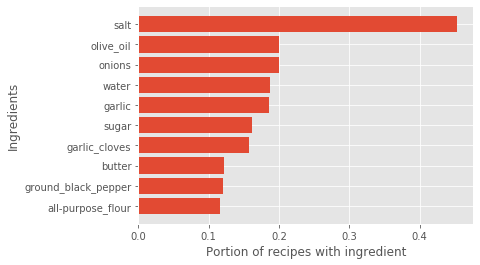

In [7]:
# Visualize top N most frequently used ingredients
N = 10

n_documents = df.shape[0]
frequent_ing = ing_by_count[:N]
prob_ing = [ing_count[item]/n_documents for item in frequent_ing]

plt.barh(frequent_ing[::-1], prob_ing[::-1])
plt.xlabel('Portion of recipes with ingredient')
plt.ylabel('Ingredients')
plt.title('')
plt.show()

The above graph shows that more than 40% of documents contain the ingredient "salt". I decided to remove the ingredient "salt" from all documents.

In [8]:
# Remove the ingredient "salt"
for i in range(df.shape[0]):
    ing = df.at[i,'ingredients']
    df.at[i,'ingredients'] = [item for item in ing if item != 'salt']

<b>(c) Create documents that have both ingredients list and cuisine type </b>

In [9]:
# get list of ingredients and list of cuisine
ing_list = df['ingredients'].tolist()
cuisine_list = df['cuisine'].tolist()

if len(ing_list) == len(cuisine_list):
    ingredients = [ing_list[i] + [cuisine_list[i]] for i in range(len(ing_list))]
else:
    print('error. Length of ingredients and cuisine does not match')    
    
# add cleaned up ingredients + cuisine to dataframe
df['document'] = ingredients

In [10]:
# add cleaned up ingredients + cuisine to dataframe
df['document'] = ingredients
df.to_csv('data/ingredient_recommendation/data.csv')

In [11]:
df.head()

,id,cuisine,ingredients,document
0,10259,greek,"[romaine_lettuce, black_olives, grape_tomatoes...","[romaine_lettuce, black_olives, grape_tomatoes..."
1,25693,southern_us,"[plain_flour, ground_pepper, tomatoes, ground_...","[plain_flour, ground_pepper, tomatoes, ground_..."
2,20130,filipino,"[eggs, pepper, mayonaise, cooking_oil, green_c...","[eggs, pepper, mayonaise, cooking_oil, green_c..."
3,22213,indian,"[water, vegetable_oil, wheat]","[water, vegetable_oil, wheat, indian]"
4,13162,indian,"[black_pepper, shallots, cornflour, cayenne_pe...","[black_pepper, shallots, cornflour, cayenne_pe..."


# 1. Preliminary analysis  

(a) Preliminary analysis. Identify potential bias in dataset    
(b) Split data into training, cross-validation, and testing set  
(c) Define metrics for evaluating different models  

<b> (a) Preliminary analysis </b>  

* About 40,000 documents(recipes) involving 6700 ingredients  
* Note the <b>potential bias</b>
    * Our dataset is biased: Some cuisine (like Italian and Mexican cuisine) are more frequently represented than some others (like Russian and brazilian cuisinze).  
    *  A recommender might recommend ingredients that go well together in mostly Italian and Mexican cuisine. 
    *  <b><font color='red'>To Do</font></b>: I might want to consider some tools for decreasing bias from my model. 

In [12]:
# load data
df = pd.read_csv('data/ingredient_recommendation/data.csv')

# Convert to format (list of lists)
documents = [ast.literal_eval(df.document[idx]) for idx in range(df.shape[0])]

In [14]:
# number of documents and ingredients
ing_list = np.unique([item for recipes in documents for item in recipes])

print('total number of recipes: ', len(ingredients))
print('total number of ingredients: ', len(np.unique(ing_list)))

total number of recipes:  39774
total number of ingredients:  6712


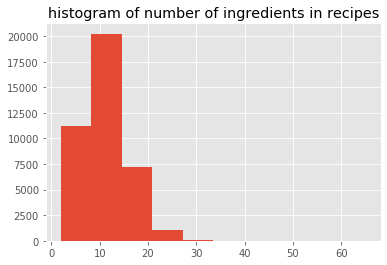

maximum number of ingredients in a given recipe:  65
minimum number of ingredients in a given recipe:  2


In [15]:
# Number of ingredients in each recipe
ing_len = [len(x) for x in ingredients]

plt.hist(ing_len)
plt.title('histogram of number of ingredients in recipes')
plt.show()
print('maximum number of ingredients in a given recipe: ', max(ing_len))  
print('minimum number of ingredients in a given recipe: ', min(ing_len))

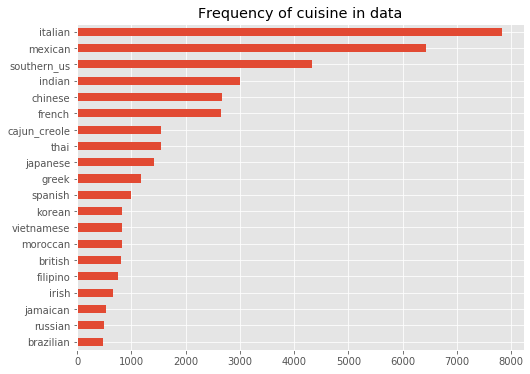

In [16]:
# Number of cuisine represented
df['cuisine'].value_counts(ascending = True).plot(kind = 'barh', figsize=(8,6))
plt.title('Frequency of cuisine in data')
plt.show()

<b> NOTE: POTENTIAL BIAS </b>
* The above graph indicates that our dataset is biased -- Italian and Mexican cuisine are represented much more than other types of cuisine.   
* One should be aware that any model trained on this dataset could potentially be biased.

<b> (B) Divide into training, cross-validation, and testing set </b>

In [17]:
# Divide into training (70%), cross-validation (15%), and testing set (15%)
n_documents = df.shape[0]
print('total number of documents: ', n_documents)

total = list(range(n_documents))
random.shuffle(total)

train_size = int(n_documents * 0.7)
cv_size = int(n_documents * 0.15)
train_idx = total[:train_size]
cv_idx = total[train_size:train_size + cv_size]
test_idx = total[train_size + cv_size:]

print('number of training set: ', len(train_idx))
print('number of cross-validation set: ', len(cv_idx))
print('number of test set: ', len(test_idx))

train_idx.sort()
cv_idx.sort()
test_idx.sort()

# save indices
f = h5py.File('data/ingredient_recommendation/train_val_test.hdf5', 'w')
f.create_dataset("train_idx", data = train_idx)
f.create_dataset("cv_idx", data = cv_idx)
f.create_dataset("test_idx", data = test_idx)
f.close()

total number of documents:  39774
number of training set:  27841
number of cross-validation set:  5966
number of test set:  5967


<b> (f) Define metric for evaluating different models</b>  
* In order to compare the performance of multiple models, I decided on a common metric to evaluate the models.  
* Use evaluation metric for classification models      
* Precision, Recall, and F-scores 
    * Precision: Of all the predicted ingredients, how much were actually true ingredients? TP / (TP + FP)
    * Recall: Of all the true ingredients, how much did we predict correctly? TP/(TP + FN)   
    * F-score : (2 * recall * precision) / (recall + precision)    
    
* Possible option: Weigh the incorrect ingredients. For example, if an incorrect predicted ingredient is still considered "similar" to an existing ingredient (maybe using word embedding features), one can still account for the incorrect prediction as a true positive with a smaller weight than 1
  

In [18]:
def sample_ingredients(ing, n_samples):  
    # For each recipe, sample "n_samples" number of ingredients randomly.
    # (If a recipe involves fewer than "n_samples" ingredients, ignore that recipe)
    # The sampled ingredients will function as the existing ingredients
    # Goal of the model is to predict the remaining ingredients that
    # have not been sampled
    
    """
    --- input ---
    ing: (list of lists) Each item of ing is a list of ingredients 
           for a particular recipe
    n_samples: (int) number of ingredients to be sampled
   
    --- output ---
    existing_ing: (list of lists) Each item of sampled_ing is a list of 
            ingredients that have been sampled
    missing_ing: (list of lists) Each item of remaining_ing is a list of ingredients
            that have not been sampled
    """
    
    existing_ing = []
    missing_ing = []
    for recipe in ing:
        if len(recipe) > n_samples:
            # randomly select 5 ingredients
            sampled = random.sample(recipe, n_samples)
            remain = list(set(recipe)-set(sampled))

            existing_ing.append(sampled)
            missing_ing.append(remain)
            
    return existing_ing, missing_ing


In [19]:
def compute_scores(predicted_ing, true_ing):
    """
    predicted_ing: (list) of predicted ingredients from the model
    true_ing: (list) of true ingredients that needed to be predicted
    """
    
    predicted_ing = set(predicted_ing)
    true_ing = set(true_ing)

    TP = len(predicted_ing.intersection(true_ing))

    precision = TP / (len(predicted_ing))
    recall = TP / len(true_ing)
    
    if recall != 0 and precision != 0:
        F_score = (2 * recall * precision)/(precision + recall)
    else:
        F_score = 0
    
    return precision, recall, F_score


In [20]:
# example 
precision, recall, F_score = compute_scores(['onions', 'scallions', 'bread'],
                                           ['scallions'])

print('precision: ' , precision)
print('recall: ', recall)
print('F_score: ', F_score)

precision:  0.3333333333333333
recall:  1.0
F_score:  0.5


# 2. Non-negative matrix factorization


<b> Summary </b> 
* Since we are building a recommender, I first tried collaborative filtering via non-negative matrix factorization. 
* The latent variables (roughly) correspond to type of cuisine, such as baking, Italian food, Mexican food, ... .  
* Non-negative matrix factorization requires the user to specify the number of latent variables (topics). I implemented two different ways of identifying the appropriate number of latent variables:
    * I first selected the number of latent variables by evaluating the recommenders on a cross-validation set. The optimal number of latent variables was 6. 
    * However, this seemed like a very low number, since our dataset clearly contains more than 6 different types of cuisine. 
    * The "optimal" number of latent variables may be very low because of the bias in our dataset. 
    * I then considered NMF as a language model, and used the coherence score to select the number of latent variables.  
    * The coherence score is maximized when we use 20 latent variables.

<b> The idea behind non-negative matrix factorization (NMF) & recommender </b>  
* Let V be a documents-ingredients matrix.
    * Each row of V corresponds to a document.
    * Each column of V corresponds to an ingredient.  
    * V [ i ][ j ] = 1 if document "i" contains ingredient "j", and 0 otherwise. 
    
* Given a matrix V, NMF factorizes V into non-negative matrices W and H such that $ W H \approx V$. 
![](files/images/NMF_annotated.png)  

* Each row of V is approximated by a linear combination of the rows of H. The coefficients of this linear combination is given by the rows of W.  
* W is a (document) x (latent topic) matrix  
* H is a (latent topic) x (ingredients) matrix   
* The factorization $ W H \approx V$ learns latent features underlying the interactions between recipes and ingredients.  
* Given a list of ingredients (a row vector $r$ in V), use the approximated row vector $\tilde r$ to recommend ingredients that have high entries in $\tilde r$. 

## 2(a) Prepare data and features

In [22]:
# load data
df = pd.read_csv('data/ingredient_recommendation/data.csv')
cuisine = list(np.unique(df.cuisine))

# Convert to correct format (list of lists)
documents = [ast.literal_eval(df.document[idx]) for idx in range(df.shape[0])]

In [23]:
# split to train and cv set
n_documents = len(documents)
document_idx = list(range(n_documents))
random.shuffle(document_idx)

cv_size = 0.3
train_idx = document_idx[int(n_documents * cv_size):]
train_doc = [documents[item] for item in train_idx]
cv_idx = document_idx[:int(n_documents * cv_size)]
cv_doc = [documents[item] for item in cv_idx]

In [24]:
# prepare (documents) x (ingredients) matrix V for NMF factorization

# Find all the ingredients
all_ingredients = list(set([item for sublist in documents for item in sublist]))

n_ingredients = len(all_ingredients)
n_documents = len(documents)

print('number of ingredients: ', n_ingredients)
print('number of documents: ', n_documents)
print('Size of training set:', len(train_idx))
print('Size of CV set:', len(cv_idx))

# Encode ingredients
idx_to_word = {idx:x for idx, x in enumerate(all_ingredients)}
word_to_idx = {value:key for key, value in idx_to_word.items()}

# create matrix V from the training set
V = np.zeros((len(train_idx), n_ingredients))
for i, doc in enumerate(train_doc):
    for ing in doc:
        j = word_to_idx[ing]
        V[i,j] = 1

number of ingredients:  6712
number of documents:  39774
Size of training set: 27842
Size of CV set: 11932


In [17]:
# choose number of ingredients to recommend
documents_len = [len(item) for item in documents]

print('mean length of documents: ', np.mean(documents_len))
print('median length of documents: ', np.median(documents_len))

mean length of documents:  11.313923668728314
median length of documents:  11.0


* Let's recommend ingredients so that one ends up with a total of 11 ingredients.  
* Since existing ingredients have 5 samples, let's recommend 6 ingredients.

In [26]:
# split each recipe in CV set into list of existing ingredients
# and missing ingredients 
existing_ing, missing_ing = sample_ingredients(cv_doc, 5)

## 2(b) Perform NMF and build an example recommender

* Note: We will use an arbitrary number of latent variables, say 50.  
* Say we found non-negative matrices W and H such that $ W H \approx V$  
* There are two different types of recommenders one can build: a deterministic and probabilistic recommender:  
    * <b> deterministic recommender </b> 
        * Given a list of ingredients, find the approximation of the document, as computed by $ W H $. Recommend ingredients with the highest coefficients in the resulting approximation.  
        * Recommended ingredients may be too similar across documents.  
        * Faster than the probabilistic recommender.  
    * <b> probabilistic recommender </b> 
        * Use the coefficients of W and H to define probability distributions. 
        * Given a list of ingredients, sample to topic. Once the topic has been selected, sample the ingredients.  
        * Introduces more variety to the recommender.  
        * Slower than the deterministic recommender. 
* Because of computational speed, we'll use the <b>deterministic recommender</b>
        

In [25]:
# Find NMF with 50 latent variables
model_50 = NMF(n_components = 50)
model_50.fit(V)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=50, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [69]:
def recommender_NMF(model, existing_ing, idx_to_word, word_to_idx, cuisine, n):
    # Deterministic recommender based on a factorized NMF model.
    # Given a list of existing ingredients, compute V_approx from NMF
    # For each document, recommend ingredients that 
    #    (1) are not present in the existing ingredients list
    #    (2) are not cuisine types
    #    (3) have high coefficients in the V_approx 
    
    """
    --- input ---
    model: trained NMF model (sklearn)
    existing_ing: (list of lists) Each item is a list of existing ingredients 
                 for a particular recipe 
    idx_to_word: (dict) from index to ingredient
    word_to_idx: (dict) from ingredient to index
    cuisine: (list) of cuisine names
    n: (int) number of ingredients to recommend
    
    --- output ---
    recommend: (list of lists) Each item is a list of "n" ingredients recommended
    """   
    
    # get parameters
    n_ingredients = len(idx_to_word)
    
    # convert existing list of ingredients into a list of indices 
    existing_idx = [[word_to_idx[item] for item in recipes] for recipes in existing_ing]
    
    # create matrix V from existing ingredients
    V = np.zeros((len(existing_ing), n_ingredients))
    for i, doc in enumerate(existing_ing):
        for ing in doc:
            j = word_to_idx[ing]
            V[i,j] = 1
            
    # find approximation to V using NNM
    H = model.components_
    W = model.transform(V)
    V_approx = np.matmul(W, H)
    
    # remove existing ingredients from V_approx (set entry to 0)
    for i, doc in enumerate(existing_idx):
        for item in doc:
            V_approx[i, item] = 0

    # remove items that are cuisine types (set entry to 0)
    cuisine_idx = [word_to_idx[item] for item in cuisine]
    V_approx[:,cuisine_idx] = 0

    # find ingredients with high coefficients in V_approx 
    V_idx = np.argsort(V_approx, axis = 1)
    V_recommend = V_idx[:,-n:].tolist()

    # turn above into list of ingredients (recommended)
    recommend = [[idx_to_word[idx] for idx in rec] for rec in V_recommend] 
    
    return recommend

In [95]:
def recommender_NMF_sample(model, existing_ing, idx_to_word, word_to_idx, cuisine, n):
    # probabilistic recommender based on a factorized NMF model.
    # The factorized NMF model results in a non-negative vector.
    # We interpret this non-negative vector as defining a probability 
    # distribution over the ingredients.  
    # Recommended ingredients are sampled according to this distribution
    
    """
    --- input ---
    model: trained NMF model (sklearn)
    existing_ing: (list of lists) Each item is a list of existing ingredients 
                 for a particular recipe 
    idx_to_word: (dict) from index to ingredient
    word_to_idx: (dict) from ingredient to index
    cuisine: (list) of cuisine names
    n: (int) number of ingredients to recommend
    
    --- output ---
    recommend_ing: (list of lists) Each item is a list of "n" ingredients recommended
    """   
    
    # get parameters and matrix H
    n_ingredients = len(idx_to_word)
    n_cuisine = len(cuisine)
    H = model.components_

    recommend_ing = []
    
    for doc in existing_ing:
        doc_length = len(doc)
        ing_list = doc.copy()
        
        while len(ing_list) < doc_length + n:
            
            # define vector of ingredients.
            ing_vector = np.zeros((1,n_ingredients))
            for item in ing_list:
                idx = word_to_idx[item]
                ing_vector[0, idx] = 1

            # get vector approximation via NMF.
            ing_W = model.transform(ing_vector)
            approx = np.matmul(ing_W, H)

            # find index of ingredients that can be recommended.
            # This excludes existing ingredients in "ing_list" 
            # and cuisine types.
            possible = [item for item in range(n_ingredients) 
                       if idx_to_word[item] not in ing_list 
                       if idx_to_word[item] not in cuisine]
            
            possible_words = [idx_to_word[item] for item in possible]
            
            # find probability distribution of ingredients
            words_prob = [approx[0,item] for item in possible]
            words_prob /= sum(words_prob)
            
            # sample ingredient
            ing_sample = np.random.choice(possible_words, 1, p=words_prob)[0]
            ing_list.append(ing_sample)
        
        # get list of recommended ingredients
        recommend = [item for item in ing_list if item not in doc]
        recommend_ing.append(recommend)
        
    return recommend_ing

In [97]:
# get recommendations
recommend = recommender_NMF(model_50, existing_ing, idx_to_word, word_to_idx, cuisine, 6)

In [99]:
# Show example recommendations 
for i in random.sample(range(len(existing_ing)),5):
    print("==================== Example "+ str(i) + " ====================" )
    print("---------- Existing ingredients ----------")
    print(existing_ing[i])
    print("---------- Recommended ingredients ----------")
    print(recommend[i])
    print("---------- Missing ingredients ----------")
    print(missing_ing[i], '\n')



==================== Example 4928 ====================
---------- Existing ingredients ----------
['fresh_thyme', 'coconut_milk', 'pig', 'cubed_pumpkin', 'water']
---------- Recommended ingredients ----------
['cilantro_leaves', 'lemongrass', 'brown_sugar', 'lime_juice', 'fresh_lime_juice', 'fish_sauce']
---------- Missing ingredients ----------
['green_onions', 'onions', 'okra', 'habanero_pepper', 'taro_leaf', 'garlic', 'blue_crabs', 'jamaican'] 

==================== Example 9923 ====================
---------- Existing ingredients ----------
['toasted_coconut', 'ground_coriander', 'coconut_milk', 'minced_garlic', 'lime_rind']
---------- Recommended ingredients ----------
['lime_juice', 'fresh_lime_juice', 'chopped_cilantro_fresh', 'fish_sauce', 'chopped_onion', 'ground_cumin']
---------- Missing ingredients ----------
['calamari', 'fish', 'indian', 'onions', 'light_brown_sugar', 'curry_powder', 'fresh_ginger', 'chopped_cilantro_fresh', 'peanut_oil', 'ground_black_pepper', 'chopped_f

## 2(c) Select number of latent variables

* To use NMF models, one needs to specify the number of latent variables  
* I used two different approaches to determine the appropriate number of latent variables

i. cross-validation evaluation of recommender built on various number of latent variables  
ii. coherence scores  

* According to the cross-validation evaluation, the number of appropriate number of topics is 5. However, I thought that this number is too low, as our dataset clearly consists of more than 5 different types of cuisine.  
* I then decided to choose the number of latent variables to be the number that leads to the highest coherence score. The optimal number of topics is 20. 


### 1(c) i. Using recommender performance on cross-validation set

In [101]:
# Evaluate NMF models of various topic numbers
topic_numbers = list(range(1, 40))
cv_scores = {}

for k in topic_numbers:
    
    # Find NMF decompositions
    model = NMF(n_components = k)
    model.fit(V)

    # make recommendations on cross validation set
    recommend_ing = recommender_NMF(model, existing_ing, idx_to_word, word_to_idx, cuisine, 6)
    
    # compute scores
    scores = [compute_scores(recommend_ing[i], missing_ing[i]) for i in range(len(missing_ing))]

    precisions = [item[0] for item in scores] 
    recalls = [item[1] for item in scores]
    Fscores = [item[2] for item in scores]
    
    cv_scores[k] = [statistics.mean(precisions), statistics.mean(recalls), statistics.mean(Fscores)]
    
# save
f = open("models/NMF/NMF_CV.pkl","wb")
pickle.dump(cv_scores,f)
f.close()

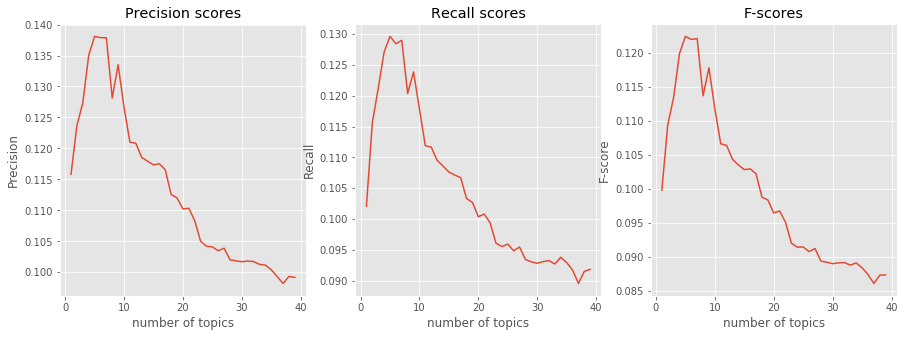

In [102]:
# open CV scores
#cv_scores = pickle.load( open( "models/NMF/NMF_CV.pkl", "rb" ) )

fig, ax = plt.subplots(ncols = 3, figsize = (15, 5))

ax[0].plot(topic_numbers, [cv_scores[item][0] for item in topic_numbers])
ax[0].set_xlabel('number of topics')
ax[0].set_ylabel('Precision')
ax[0].set_title('Precision scores')

ax[1].plot(topic_numbers, [cv_scores[item][1] for item in topic_numbers])
ax[1].set_xlabel('number of topics')
ax[1].set_ylabel('Recall')
ax[1].set_title('Recall scores')

ax[2].plot(topic_numbers, [cv_scores[item][2] for item in topic_numbers])
ax[2].set_xlabel('number of topics')
ax[2].set_ylabel('F-score')
ax[2].set_title('F-scores')
plt.show()

F-score is maximized when number of topics is around 5 - 7.  
Let's see some examples of the recommended ingredients

In [107]:
# Factorize matrix with 5 latent variables
model_5 = NMF(n_components = 5)
model_5.fit(V)

# manually inspect some example recommendations
recommend_ing = recommender_NMF(model_5, existing_ing[:5], idx_to_word, word_to_idx, cuisine, 6)

# Show example recommendations 
for i in random.sample(range(len(existing_ing)),5):
    print("==================== Example "+ str(i) + " ====================" )
    print("---------- Existing ingredients ----------")
    print(existing_ing[i])
    print("---------- Recommended ingredients ----------")
    print(recommend[i])
    print("---------- Missing ingredients ----------")
    print(missing_ing[i], '\n')


==================== Example 356 ====================
---------- Existing ingredients ----------
['ground_cumin', 'large_garlic_cloves', 'cayenne_pepper', 'carrots', 'yellow_onion']
---------- Recommended ingredients ----------
['onion_powder', 'chopped_cilantro_fresh', 'ground_coriander', 'paprika', 'tomato_paste', 'garlic_powder']
---------- Missing ingredients ----------
['low_sodium_chicken_broth', 'sour_cream', 'ground_coriander', 'extra-virgin_olive_oil', 'mexican', 'black_beans', 'oregano', 'fresh_lime_juice', 'chopped_cilantro_fresh'] 

==================== Example 4154 ====================
---------- Existing ingredients ----------
['light_coconut_milk', 'green_onions', 'sweet_potatoes', 'garlic_chili_sauce', 'fresh_lime_juice']
---------- Recommended ingredients ----------
['beansprouts', 'chopped_cilantro_fresh', 'coconut_milk', 'brown_sugar', 'sesame_oil', 'fish_sauce']
---------- Missing ingredients ----------
['fat_free_less_sodium_chicken_broth', 'lemongrass', 'olive_oil

In [111]:
# some more examples
examples = [['korean','chicken'], 
            ['thai','chicken'],
            ['indian', 'chicken']]

recommend_ing = recommender_NMF(model_5, examples, idx_to_word, word_to_idx, cuisine, 6)

for i in range(len(examples)):
    print("===== EXAMPLE =====")
    print(" Existing ingredients: ", examples[i])
    print(" Recommended ingredients: ", recommend_ing[i], '\n')


===== EXAMPLE =====
 Existing ingredients:  ['korean', 'chicken']
 Recommended ingredients:  ['vegetable_oil', 'sesame_oil', 'garlic', 'sugar', 'soy_sauce', 'water'] 

===== EXAMPLE =====
 Existing ingredients:  ['thai', 'chicken']
 Recommended ingredients:  ['green_onions', 'garlic', 'sesame_oil', 'sugar', 'soy_sauce', 'water'] 

===== EXAMPLE =====
 Existing ingredients:  ['indian', 'chicken']
 Recommended ingredients:  ['carrots', 'tomatoes', 'water', 'pepper', 'garlic', 'onions'] 



<b> The need for a different number of latent variables </b>  
* While the cross-validation evaluation method found the optimal number of topics to be 5, I thought that this number was too low.  
* Our dataset clearly has more than 5 topics. Performing NMF with 5 latent oversimplifies the different types of cuisine we have.  
* For example, the last cell shows the recommended ingredients for three different types of cuisine involving chicken. Note that basically identical ingredients are recommended for both Korean and Thai style cooking.  


### 1(c) ii. Using coherence scores
* We'll select the number of latent variables to be the number of topics that maximizes coherence scores
* For computing the coherence score, we'll use NMF via gensim

In [113]:
# Prepare data for gensim

# Create dictionary
common_dictionary = Dictionary(documents)

# Prepare BOW features for training set
train_text = [documents[idx] for idx in train_idx]
train_corpus = [common_dictionary.doc2bow(text) for text in train_text]  

# Prepare CV set text for computing coherence scores
#cv_text = [documents[idx] for idx in cv_idx]

In [353]:
# compute coherence scores for NMF models of various topic numbers
topic_numbers = list(range(1,100,4))
scores = {}

for k in topic_numbers:
    # train NMF model 
    nmf = Nmf(train_corpus, id2word = common_dictionary, num_topics = k)
   
    # compute coherence on cv
    cm = CoherenceModel(model=nmf, texts=cv_text, window_size = 60, coherence='c_uci')
    coherence = cm.get_coherence() 
    scores[k] = coherence
    
# save
f = open("models/NMF/NMF_coherence.pkl","wb")
pickle.dump(scores,f)
f.close()

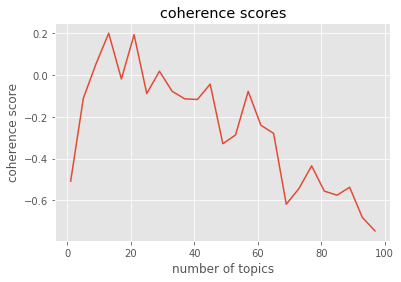

In [354]:
plt.plot(topic_numbers, [scores[item] for item in topic_numbers])
plt.xlabel('number of topics')
plt.ylabel('coherence score')
plt.title('coherence scores')
plt.show()

Based on the above graph, the number of topics that leads to the highest coherence score is 20.  
For fun, let's take a look at the topics learned by the 20 topics

In [114]:
# load index for train, cv, test
f = h5py.File('data/ingredient_recommendation/train_val_test.hdf5', 'r')
train_idx = list(f.get("train_idx"))
cv_idx = list(f.get("cv_idx"))
test_idx = list(f.get("test_idx"))
f.close()

# Prepare BOW features for training set
train_text = [ingredients[idx] for idx in train_idx]
train_corpus = [common_dictionary.doc2bow(text) for text in train_text]  

In [115]:
# train NMF model 
gensim_nmf = Nmf(train_corpus, id2word = common_dictionary, num_topics = 20)

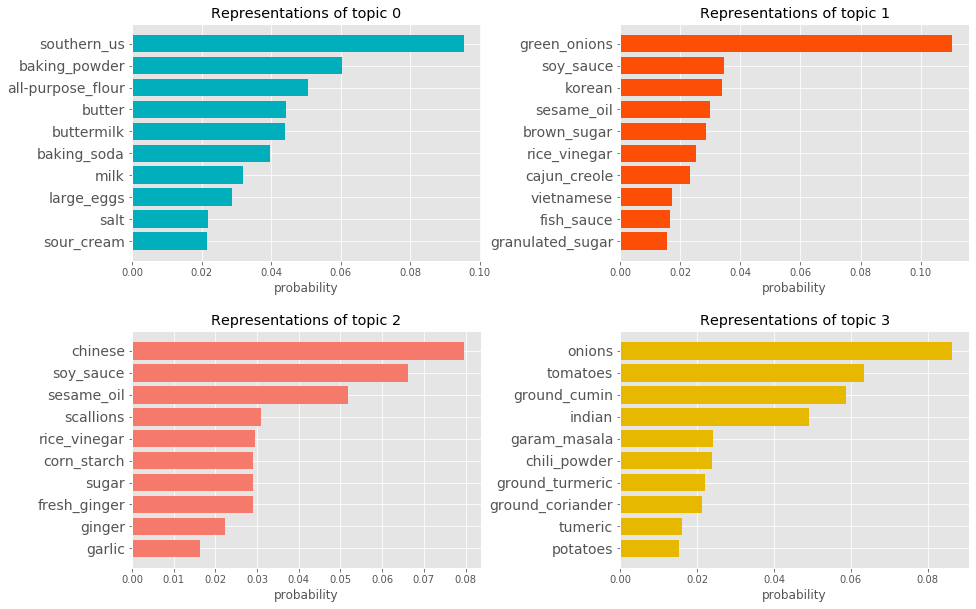

In [481]:
# Visualize topic representations for 4 (out of 20) topics
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
colors = ["#00AFBB", "#FC4E07", "#f57a6c", "#E7B800"]
for i in range(4):
    row = i // 2
    col = i % 2
    
    topic_rep = gensim_nmf.show_topic(i)
    words = [item[0] for item in topic_rep][::-1]
    prob = [item[1] for item in topic_rep][::-1]
    
    ax[row][col].barh(words, prob, color = colors[i])
    ax[row][col].tick_params(axis="y", labelsize=14)
    ax[row][col].set_xlabel('probability')
    ax[row][col].set_title('Representations of topic '+ str(i))
    
fig.subplots_adjust(wspace=0.4, hspace = 0.3)
plt.show()

The above graph shows the top 10 most probable ingredients for 4 of the 20 topics learned by NMF. 
* Topic 1 seems to represent ingredients for baking / southern food  
* Topic 2 seems to represent ingredients for east asian cuisine, excluding Chinese food  
* Topic 3 seems to represent ingredients for Chinese cuisine  
* Topic 4 seems to represent ingredients for Indian cuisine 



## 2(d) Build a recommender

In [117]:
# Find NMF with 20 latent variables
model_20 = NMF(n_components = 20)
model_20.fit(V)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=20, random_state=None, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [118]:
# get recommendations
recommend = recommender_NMF(model_20, existing_ing, idx_to_word, word_to_idx, cuisine, 6)

In [119]:
# Show example recommendations 
for i in random.sample(range(len(existing_ing)),5):
    print("==================== Example "+ str(i) + " ====================" )
    print("---------- Existing ingredients ----------")
    print(existing_ing[i])
    print("---------- Recommended ingredients ----------")
    print(recommend[i])
    print("---------- Missing ingredients ----------")
    print(missing_ing[i], '\n')

==================== Example 9015 ====================
---------- Existing ingredients ----------
['salt_and_ground_black_pepper', 'pears', 'prosciutto', 'pizza_crust', 'cornmeal']
---------- Recommended ingredients ----------
['baking_powder', 'vegetable_oil', 'green_onions', 'grated_parmesan_cheese', 'milk', 'eggs']
---------- Missing ingredients ----------
['shredded_swiss_cheese', 'fresh_mozzarella', 'olive_oil', 'italian', 'garlic', 'all-purpose_flour'] 

==================== Example 8033 ====================
---------- Existing ingredients ----------
['saffron', 'chili_oil', 'tomatoes', 'sweet_mustard', 'onions']
---------- Recommended ingredients ----------
['tomato_paste', 'ground_cumin', 'chicken_broth', 'potatoes', 'green_bell_pepper', 'carrots']
---------- Missing ingredients ----------
['indian', 'green_chilies', 'coriander', 'cauliflower', 'extra-virgin_olive_oil', 'garam_masala', 'curry_leaves', 'water', 'garbanzo_beans'] 

==================== Example 487 ===============

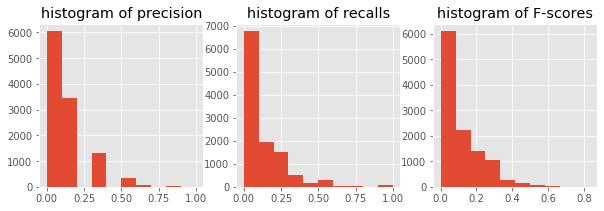

Average precision on cross validation set:  0.111841131729261
Average recall on cross validation set:  0.10258207928402006
Average F-score on cross validation set:  0.0982910401011372


In [122]:
scores = [compute_scores(recommend[i], missing_ing[i]) for i in range(len(missing_ing))]

precisions = [item[0] for item in scores] 
recalls = [item[1] for item in scores]
Fscores = [item[2] for item in scores]

fig, ax = plt.subplots(ncols = 3, figsize = (10,3))
ax[0].hist(precisions)
ax[0].set_title('histogram of precision')

ax[1].hist(recalls)
ax[1].set_title('histogram of recalls')

ax[2].hist(Fscores)
ax[2].set_title('histogram of F-scores')
plt.show()

print("Average precision on cross validation set: ", statistics.mean(precisions) )
print("Average recall on cross validation set: ", statistics.mean(recalls) )
print("Average F-score on cross validation set: ", statistics.mean(Fscores) )

The model doesn't seem to perform very well as a recommendation system. See the following section for ideas for improvement.

## 2(e) Ideas for improvement

1. Selecting the number of latent variables
    * Evaluation on cross-validation resulted in 6 latent variables. The coherence score resulted in 20 latent variables.
    * Note that 20 is still a low number of latent variables. For example, one of the topics (topic 1) represented a mix of various east asian cuisine excluding Chinese cuisine. A recommender based on this model could recommend a mix of ingredients that do not necessarily go well together. 
    * Cross-validation for unsupervised learning models can be difficult. There are some other ways to perform cross-validation on NMF, as illustrated in this <a href="http://alexhwilliams.info/itsneuronalblog/2018/02/26/crossval/">blog post</a>.    
2. Tackling bias in dataset.  
    * We can gather more data to create a more diverse dataset.  
3. Sampling based recommender.  
    * In order to add variety to the ingredients recommended, we can build a recommender that sample ingredients according to a probability distribution determined by NMF model. We will need more computing power for this to be feasible. 
    * Try cloud computing.  
4. Differentiating unknown values from 0s.
    * Given a list of ingredients, the list is represented by a row vector of 0s and 1s, where 1 is assigned if the ingredient is present.  
    * While we use the 0s to indicate the fact that it is unknown whether the ingredient should be present or not, sklearn treats 0s as observed absence of an ingredient.   
    * There are ways to perform NMF while differentiating missing / unknown values from 0s. One can write a custom SGD to optimize the cost function only based on the observed ingredients.  
    * While differentiating the unknown values from 0s would be more accurate for our problem, I'm not sure if this will necessarily lead to a better performing recommender.  

# 3. Word embeddings  

<b> Why word embeddings? </b>  
I thought that the word analogies of word embeddings would be useful in understanding questions like "what vegetable would go well with lamb?". I was also inspired by other data scientists who used word embeddings for context-dependent recommenders. (Examples: <a href="https://towardsdatascience.com/using-word2vec-for-music-recommendations-bb9649ac2484">music recommendation</a>, <a href="https://multithreaded.stitchfix.com/blog/2015/03/11/word-is-worth-a-thousand-vectors/">stitch fix</a>, <a href="https://www.nature.com/articles/s41586-019-1335-8">material science</a>, and <a href="http://mccormickml.com/2018/06/15/applying-word2vec-to-recommenders-and-advertising/"> many others </a>)

I investigated two possibilities with word embeddings. 
 
1. Can word analogies be useful in understanding questions like "what vegetable would go well with lamb?"  
2. What is the relationship between ingredients that have similar vector representations? Are they substitutes? complementary? Depending on the answer to this question, I can then attempt to build a recommendation system from word embeddings

In this section, I investigate the above two questions for Word2Vec and GloVe embeddings.  
* I started with Word2Vec because more familiar with the model.  
* However, for this particular project, I realized that GloVe may be better suited for this project.

Some explanation for why I studied GloVe as well:

Note that Word2Vec extracts embeddings from a neural network designed to perform a surrogate task. In the continuous-bag-of-words (CBOW) model, the surrogate tasks is to predict a word given the surrounding context words. The size of this context can be defined by the user. I wanted to remove this dependence on the size of the context because of the following reason:

Say we have a recipe with 10 ingredients:[i0, i1, i2, ... , i9] 
If we chose a context size of 2 words to the left and right, then the surrogate task would attemt to solve the following task:
    * From ingredients (i0, i1, i3, i4), predict i2
    * From ingredients (i1, i2, i4, i5), predict i3, and so on.
Thus, according to the model, ingredient i9 does not appear in the context of i0. However, we do want all ingredients belonging to the same recipe to be considered as being in the same context.  

There are ways to work around this. (1) We can permute the order of ingredients in each recipe, and hope that we have a large enough training set. (2) We could also add to the training set some different permutations of the ingredients. (3) We could use GloVe.

GloVe learns word embeddings based on the co-occurrence count of words. In this case, any two ingredients that appear together in the same recipe will be considered as co-occuring words. 


<b> Summary </b>
* Given a word, the most similar words are sometimes
    * substitutes and similar ingredients
    * complementary ingredients
* For example, when we ask for the closest ingredient to "chicken" (using the GloVe model), we get: garlic, onions, chicken stock, chicken broth, chicken breasts, sauce, pepper, .... 
    * While garlic and onions are considered good complementary ingredients, ingredients like chicken stock, chicken broth, chicken breasts similar items that we do not necessarily need. 
* We only want "complementary ingredients". 



## 2(a) word embeddings: word2vec  

I played around with three different kinds of word2vec models:  
i) Pre-trained Word2Vec model    
ii) A Worc2Vec model trained on our data

I went through the three models for the following reasons: 
* I started with the pre-trained Word2Vec model from the Google News dataset. 
* While the pre-trained model has the advantage of easy use, it takes a <b>long time to load the model and to query</b> the embedding, probably because the model contains 3 millioin words and phrases.   
* Furthermore, some queries resulted in words that are <b>irrelevant to cooking.</b> 
* For this project, I decided that training a Word2Vec model on just cooking-related terms would be (1) faster to use and (2) more relevant to our project.  
 
 
* I then decided to train a Word2Vec model using recipe directions. 
* The resulting model was much faster to query than the pre-trained model, and the results were more cooking-specific.  

In [157]:
# prepare data
# load data
df = pd.read_csv('data/ingredient_recommendation/data.csv')
cuisine = list(np.unique(df.cuisine))

# Convert to correct format (list of lists)
documents = [ast.literal_eval(df.document[idx]) for idx in range(df.shape[0])]

# randomly shuffle the order of ingredients in each document
for item in documents:
    random.shuffle(item)

###  2(a) i) pre-trained word2vec model

* pre-trained word2vec model from the <a href="https://code.google.com/archive/p/word2vec/">Google News dataset</a>
* The model contains 300-dimensional vectors for 3 million words and phrases  
* You should download the pre-trained model in the <a href="https://code.google.com/archive/p/word2vec/">Google Code Archive</a>

In [178]:
# load pre-trained word2vec model
path_googlenews = 'models/word2vec/GoogleNews-vectors-negative300.bin'
pretrained_word2vec= gensim.models.KeyedVectors.load_word2vec_format(path_googlenews, binary=True) 

FileNotFoundError: [Errno 2] No such file or directory: 'models/word2vec/GoogleNews-vectors-negative300.bin'

In [5]:
pretrained_word2vec.similar_by_word('steak',topn=15,restrict_vocab=None)

[('steaks', 0.7992713451385498),
 ('filet_mignon', 0.7782121896743774),
 ('porterhouse', 0.7527751922607422),
 ('sirloin', 0.7395126819610596),
 ('prime_rib', 0.7364764213562012),
 ('filet', 0.7349370718002319),
 ('porterhouse_steak', 0.7305288314819336),
 ('tenderloin', 0.7280069589614868),
 ('roast_beef', 0.7186790108680725),
 ('rib_eye', 0.7158585786819458),
 ('ribeye_steak', 0.7071082592010498),
 ('sirloin_steak', 0.7050917744636536),
 ('ribeye', 0.701675295829773),
 ('hanger_steak', 0.6981855630874634),
 ('striploin', 0.6928503513336182)]

### 2(a) iii) Train a word2vec model

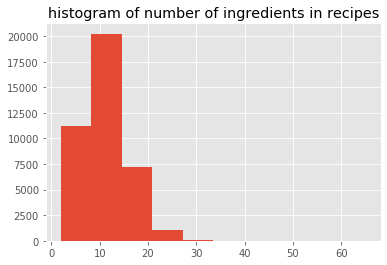

maximum number of ingredients in a given recipe:  65
minimum number of ingredients in a given recipe:  2


In [171]:
# Given a document and an ingredient, use all other ingredients in the same document as context

# Number of ingredients in each recipe
ing_len = [len(x) for x in ingredients]

plt.hist(ing_len)
plt.title('histogram of number of ingredients in recipes')
plt.show()
print('maximum number of ingredients in a given recipe: ', max(ing_len))  
print('minimum number of ingredients in a given recipe: ', min(ing_len))

In [172]:
# train word2vec
embedding_dim=300
model=gensim.models.Word2Vec(documents, size=embedding_dim, window=64, min_count=0)

In [173]:
model.wv.most_similar('steak',topn=15,restrict_vocab=None)

[('liquid', 0.8937506675720215),
 ('refrigerated_biscuits', 0.8931505680084229),
 ('bihon', 0.8890092968940735),
 ('carne_seca', 0.8880493640899658),
 ('dumplings', 0.8871213793754578),
 ('soup', 0.8839828372001648),
 ('annatto', 0.8816198706626892),
 ('pork_sirloin_chops', 0.8783628940582275),
 ('chicken_base', 0.8753625154495239),
 ('pancit_canton', 0.8726178407669067),
 ('marmite', 0.872413158416748),
 ('pork_chops', 0.8696330785751343),
 ('organic_chicken', 0.8670274615287781),
 ('onion_soup_mix', 0.8662793040275574),
 ('catfish', 0.8659968376159668)]

In [174]:
model.wv.most_similar('chicken', topn = 15)

[('feet', 0.8354811072349548),
 ('spices', 0.8242486715316772),
 ('low_sodium_chicken_stock', 0.8213478326797485),
 ('bone-in_chicken', 0.8161294460296631),
 ('meat', 0.8145659565925598),
 ('pork_shoulder', 0.8142184019088745),
 ('chicken_thighs', 0.809796929359436),
 ('chuck', 0.8074085712432861),
 ('chicken_pieces', 0.802112877368927),
 ('diced_potatoes', 0.7993303537368774),
 ('stewing_beef', 0.7985884547233582),
 ('rice', 0.7953746318817139),
 ('himalayan_salt', 0.7937618494033813),
 ('chicken_stock', 0.7895725965499878),
 ('thyme', 0.7836822271347046)]

<b> Word analogies </b> 
* Let's say I'm cooking lamb, and I want to know what vegetable would go well with lamb. 
* I can use known protein-vegetable pairings, such as steak & asparagus, to ask the word embedding to solve the following word analogy problem  
    <b>steak</b> is to <b>asparagus</b> as <b>lamb</b> is to <b>?</b>   
    i.e., steak : asparagus = lamb : ?  
* That is, we want to find the ingredient that best satisfies the following:  
    wv['asparagus']-wv['steak'] = wv[?] - wv['lamb'], or
    wv[?] = wv['lamb'] + wv['asparagus'] - wv['steak']
    

In [175]:
model.wv.similar_by_vector(model.wv['lamb']+model.wv['asparagus']-model.wv['steak'],restrict_vocab=None)

[('fennel_bulb', 0.9200878143310547),
 ('yellow_crookneck_squash', 0.9186364412307739),
 ('fennel', 0.8993750810623169),
 ('hot_red_pepper_flakes', 0.8906301856040955),
 ('fronds', 0.885313868522644),
 ('florets', 0.8820755481719971),
 ('brine-cured_black_olives', 0.8779783248901367),
 ('nonfat_chicken_broth', 0.8712207078933716),
 ('asparagus', 0.8650274276733398),
 ('italian_parsley_leaves', 0.8641363382339478)]

<b> Cooking in style </b>  
* What if I wanted to cook a particular ingredient in a particular cuisine?  
* For example, if I wished to cook chicken in an Indian style cuisine, what other ingredients would go well?

In [176]:
model.wv.similar_by_vector(model.wv['chicken'] + model.wv['indian'],topn=15)


[('indian', 0.9711512327194214),
 ('garam_masala', 0.8860338926315308),
 ('ground_turmeric', 0.8840551376342773),
 ('curry_leaf', 0.8732288479804993),
 ('cumin_seed', 0.8500876426696777),
 ('tumeric', 0.8456149697303772),
 ('basmati_rice', 0.8206949234008789),
 ('legumes', 0.8155329823493958),
 ('low-fat_natural_yogurt', 0.8097508549690247),
 ('fenugreek', 0.8060717582702637),
 ('mustard_seeds', 0.8035770654678345),
 ('curry_leaves', 0.7989659905433655),
 ('fenugreek_leaves', 0.7989515662193298),
 ('black_mustard_seeds', 0.7975561618804932),
 ('fenugreek_seeds', 0.7969434261322021)]

<b>Recommending new ingredients from existing ingredients </b>  
* For example, let's say I want to cook my chicken in Korean style, and I have the following ingredients: chicken, onions, sesame seeds.  
* Can the model recommend some other ingredients that would go well?  

In [177]:
model.wv.similar_by_vector(model.wv['chicken'] + model.wv['korean']
                           + model.wv['onions'] + model.wv['sesame_seeds'],topn=15)

[('sandwich_steak', 0.8764801621437073),
 ('gochujang_base', 0.8689554929733276),
 ('rice_wine', 0.84215247631073),
 ('sesame_oil', 0.8416028618812561),
 ('dried_kelp', 0.8391591906547546),
 ('chili_pepper_flakes', 0.8330817818641663),
 ('fried_eggs', 0.8319185972213745),
 ('soybean_paste', 0.8308249711990356),
 ('korean', 0.8302420377731323),
 ('asian_pear', 0.825729489326477),
 ('beef_ribs', 0.82475745677948),
 ('pear_juice', 0.8183329105377197),
 ('gluten_free_soy_sauce', 0.8052204847335815),
 ('sodium_free_chicken_broth', 0.8038865327835083),
 ('cress', 0.8031630516052246)]

* 'Other vegetables' is good for our diet but really not helpful right now..  
* The other recommendations do seem helpful and in line with Korean style cuisine


## 2(b) word embeddings using GloVe  

* Similar to word2vec, but based on a co-occurence statistics  
* Had to use these on my mac  
* Note: training GloVe isn't done in this notebook
* This section simply prepares the text for training and analyzes the result 
* Does GloVe depend on how close the words are? Or is it just about co-occurrence in the same document? 

In [29]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.keyedvectors import KeyedVectors

<b> Prepare text for training GloVe</b> 
* According to <a href="https://github.com/stanfordnlp/GloVe/tree/master/src">GloVe README file</a>, we should prepare our text file according to the following. 
    * Prepare corpus as a single text file
    * Words should  be separated by one or more spaces or tabs
    * Multiple documents should be separated by new line characters. Cooccurrence contexts for words do not extend past newline characters

In [5]:
# print current format
print(ing_cuisine[:10])

[['romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles', 'greek'], ['plain flour', 'ground pepper', 'salt', 'tomatoes', 'ground black pepper', 'thyme', 'eggs', 'green tomatoes', 'yellow corn meal', 'milk', 'vegetable oil', 'southern_us'], ['eggs', 'pepper', 'salt', 'mayonaise', 'cooking oil', 'green chilies', 'grilled chicken breasts', 'garlic powder', 'yellow onion', 'soy sauce', 'butter', 'chicken livers', 'filipino'], ['water', 'vegetable oil', 'wheat', 'salt', 'indian'], ['black pepper', 'shallots', 'cornflour', 'cayenne pepper', 'onions', 'garlic paste', 'milk', 'butter', 'salt', 'lemon juice', 'water', 'chili powder', 'passata', 'oil', 'ground cumin', 'boneless chicken skinless thigh', 'garam masala', 'double cream', 'natural yogurt', 'bay leaf', 'indian'], ['plain flour', 'sugar', 'butter', 'eggs', 'fresh ginger root', 'salt', 'ground cinnamon', 'milk', 'vanilla extract', 'ground ginger', 'p

In [21]:
# In Glove, spaces are used to separate words.
# Ingredients that involve spaces should be adjusted

# for each recipe, replace spaces with underscore, and join all ingredients into one string
glove_training = []

for recipe in ing_cuisine:
    # replace spaces in ingredients with underscore
    recipe_new = [item.replace(' ','_') for item in recipe]
    
    # join ingredients into a string and add newline character 
    glove_training.append(' '.join(recipe_new)+'\n')

In [23]:
f = open("model/glove/glove_training.txt", "w")
f.writelines(glove_training)
f.close()

In [28]:
# Double check that we have the correct file format
# the following should give ingredients of the first two cuisine
#f = open('data/glove/glove_training.txt','r')
#print(f.readline())
#print(f.readline())
#f.close()

romaine_lettuce black_olives grape_tomatoes garlic pepper purple_onion seasoning garbanzo_beans feta_cheese_crumbles greek

plain_flour ground_pepper salt tomatoes ground_black_pepper thyme eggs green_tomatoes yellow_corn_meal milk vegetable_oil southern_us



<b> Training on GloVe </b>  
* Clone <a href="https://github.com/stanfordnlp/GloVe">GloVe repository</a> 
* Run "make" 
* Copy the "glove_training.txt" file to the glove directory 
* Edit the "demo.sh" file:
    * Remove the 9 lines after "make" starting with "if" and ending with "fi"  
    * Edit right side of "CORPUS=" with file name "glove_training.txt"  
* Run "./demo.sh" 
* The word vectors will be saved in the "vectors.txt" file. 

<b> GloVe results </b>  
* Vocab size: 3357
* Vector size: 50
* Cost: 0.0325



In [ ]:
# Note: GloVe returns the statistics of co-occurrence and the word embeddings
# it doesn't return a model like word2vec that can be used to predict surrounding words
# Just have to do the best with the embeddings themselves

In [30]:
# convert GloVe vector text format into word2vec text format
# This way, we can use gensim to do word comparisons and analysis
glove2word2vec(glove_input_file="model/glove/glove_vectors.txt", 
               word2vec_output_file="model/glove/gensim_glove_vectors.txt")

/usr/local/lib/python2.7/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


(3358, 50)

In [32]:
glove_model = KeyedVectors.load_word2vec_format("model/glove/gensim_glove_vectors.txt", binary=False)

In [35]:
glove_model.most_similar('steak',topn=15,restrict_vocab=None)

[('cod', 0.6614221930503845),
 ('panko_breadcrumbs', 0.6294422149658203),
 ('pork_chops', 0.5919418334960938),
 ('tonkatsu_sauce', 0.5722765922546387),
 ('beaten_eggs', 0.5602886080741882),
 ('flour', 0.5539854764938354),
 ('frozen_peas_and_carrots', 0.49084463715553284),
 ('min', 0.4804944396018982),
 ('panko', 0.4743003249168396),
 ('chives', 0.4698525071144104),
 ('sweet_chili_sauce', 0.4662887454032898),
 ('ramen_noodles', 0.45906150341033936),
 ('ground_chicken', 0.44420695304870605),
 ('Chinese_rice_vinegar', 0.4360998868942261),
 ('chorizo', 0.43559232354164124)]

In [39]:
glove_model.most_similar('chicken',topn=15,restrict_vocab=None)

[('garlic', 0.7296680808067322),
 ('onions', 0.6966990232467651),
 ('chicken_stock', 0.6510413885116577),
 ('chicken_broth', 0.6387048363685608),
 ('chicken_breasts', 0.626524806022644),
 ('sauce', 0.6245228052139282),
 ('pepper', 0.620618462562561),
 ('yellow_onion', 0.614948570728302),
 ('spices', 0.6102616190910339),
 ('rice', 0.6061379909515381),
 ('bay_leaves', 0.6036665439605713),
 ('cilantro', 0.6028690338134766),
 ('tomatoes', 0.6022893190383911),
 ('kosher_salt', 0.5862119197845459),
 ('bay_leaf', 0.5841464400291443)]

In [37]:
glove_model.similar_by_vector(glove_model['lamb'] + glove_model['asparagus']- glove_model['steak'],topn=15,restrict_vocab=None)


[('couscous', 0.6679390668869019),
 ('asparagus', 0.6486406326293945),
 ('spinach_leaves', 0.6287509799003601),
 ('tahini', 0.62239009141922),
 ('garbanzo_beans', 0.5981909036636353),
 ('fresh_lemon_juice', 0.5812668800354004),
 ('chickpeas', 0.5755916833877563),
 ('pinenuts', 0.5707820653915405),
 ('lemon_zest', 0.5574780702590942),
 ('orzo', 0.5545808672904968),
 ('grated_lemon_peel', 0.5538576245307922),
 ('lamb', 0.5468550324440002),
 ('chopped_fresh_mint', 0.542788565158844),
 ('preserved_lemon', 0.5352820158004761),
 ('arborio_rice', 0.5287206768989563)]

In [38]:
glove_model.similar_by_vector(glove_model['chicken'] + glove_model['korean'],topn=15)

[('korean', 0.8404902219772339),
 ('toasted_sesame_seeds', 0.7193809747695923),
 ('sesame_seeds', 0.713943362236023),
 ('Gochujang_base', 0.7067477703094482),
 ('sesame_oil', 0.702775239944458),
 ('soy_sauce', 0.6895512342453003),
 ('asian_pear', 0.67808997631073),
 ('kimchi', 0.6725336313247681),
 ('beef', 0.6577582955360413),
 ('green_onions', 0.655651330947876),
 ('ginger', 0.642991304397583),
 ('rice_wine', 0.6344742774963379),
 ('sauce', 0.6225952506065369),
 ('chicken', 0.6196356415748596),
 ('noodles', 0.6129593849182129)]

# 4. Continuous-Bag-Of-Words model

* Note that Word2Vec embeddings are learned while training a neural network to perform a supervised learaning task.
* In particular, the Continuous-Bag-Of-Words (CBOW) model word embeddings are obtained while training a model that predicts a target word given the context words.  
* In this section, we train a CBOW model to predict an ingredient given other ingredients in the same recipe.   

<b> Continuous-Bag-Of-Words model </b>  
* Say we are building a CBOW model that takes 4 context words to predict a target word.  
* In a CBOW 
* Given an example text "this project builds an ingredient recommender", the example text generates the following training data 

Example text | Context | Target |  
--- | --- | --- |
<b>this</b>  <font color='blue'>project builds</font> an ingredient recommender | <font color='blue'>project,builds</font> | <b>this</b> | 
<font color='blue'>this</font> <b>project</b> <font color='blue'>builds an</font> ingredient recommender | <font color='blue'>this, builds, an</font> | <b>project</b> |
<font color='blue'>this project</font> <b>builds</b> <font color='blue'>an ingredient</font> recommender | <font color='blue'>this, project, an, ingredient</font>  | <b>builds</b> |  
this <font color='blue'>project builds</font> <b>an</b> <font color='blue'>ingredient recommender</font> | <font color='blue'>project, builds, ingredient, recommender</font>  | <b>an</b>| 
this project <font color='blue'>builds an</font> <b>ingredient</b> <font color='blue'>recommender</font> | <font color='blue'>builds, an, recommender</font>  | <b>ingredient</b>| 
this project builds <font color='blue'>an ingredient</font> <b>recommender</b> | <font color='blue'>an, ingredient</font> | <b>recommender</b>| 

<b> CBOW model for predicting ingredients from "context" ingredients </b>  
* In the CBOW model, the context consists of words that are in the neighborhood of the target word. 
* For ingredient recommendations, the context should be the collection of ingredients that belong in the same recipe as a given target ingredient.  
* For example, let's say we are given a cheesecake recipe with the following ingredients: "cream cheese", "eggs","sugar","vanilla extract","lemon zest","sour cream". Given the target word "cream cheese", there are 5 choices for context of size 4:  
    * "eggs", "sugar", "vanilla extract", "lemon zest" 
    * "eggs", "sugar", "vanilla extract", "sour cream"  
    * "eggs", "sugar", "lemon zest", "sour cream"  
    * "eggs", "vanilla extract", "lemon zest", "sour cream"  
    * "sugar", "vanilla extract", "lemon zest", "sour cream"  
* As this example shows, the context words are no longer the words in the neighborhood of a target word. Instead, context words are other ingredients that are used in the same recipe.  
* In order to create training dataset whose conext is described above, I randomly permuted the order of the ingredients in each recipe. Let's say the ingredients now appear in the following order after random permutations: "lemon zest", "eggs", "vanilla extract", "sour cream", "sugar". Such list of ingredients generates the following training data: 
    
    
Example recipe | Context | Target |  
--- | --- | --- |
<b>lemon zest</b>,  <font color='blue'>eggs, vanilla extract,</font> sour cream, sugar | <font color='blue'>project,builds</font> | <b>this</b> | 
<font color='blue'>this</font> <b>project</b> <font color='blue'>builds an</font> ingredient recommender | <font color='blue'>this, builds, an</font> | <b>project</b> |
<font color='blue'>this project</font> <b>builds</b> <font color='blue'>an ingredient</font> recommender | <font color='blue'>this, project, an, ingredient</font>  | <b>builds</b> |  
this <font color='blue'>project builds</font> <b>an</b> <font color='blue'>ingredient recommender</font> | <font color='blue'>project, builds, ingredient, recommender</font>  | <b>an</b>| 
this project <font color='blue'>builds an</font> <b>ingredient</b> <font color='blue'>recommender</font> | <font color='blue'>builds, an, recommender</font>  | <b>ingredient</b>| 
this project builds <font color='blue'>an ingredient</font> <b>recommender</b> | <font color='blue'>an, ingredient</font> | <b>recommender</b>|    




* While you can train a vanila neural network, we'll use the Word2Vec model provided by gensim since it is extremely easy to use  
* I was concerned about the order of the words.
    * The model itself isn't concerned with the order of words appearing in the neighborhood. 
    * A list of ingredients ofr a recipes should be best considered as an unordered set. 
    * However, this means that not all neighbor relations (that should be represented) won't exist

## 3.0 Example

Decide on the appropriate window size

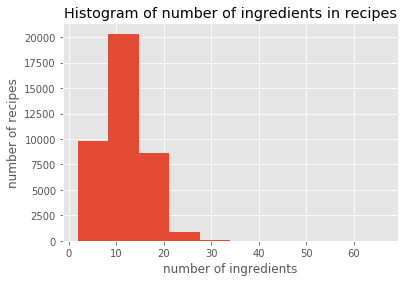

maximum number of ingredients: 66
minimum number of ingredients: 2


In [120]:
# what is the appropriate window size?
ing_length = [len(item) for item in ingredients]
plt.hist(ing_length)
plt.title('Histogram of number of ingredients in recipes')
plt.xlabel('number of ingredients')
plt.ylabel('number of recipes')
plt.show()

print('maximum number of ingredients:', max(ing_length))
print('minimum number of ingredients:', min(ing_length))

In [121]:
# randomly shuffle each ingredient list
for item in ingredients:
    random.shuffle(item)


In [122]:
# train model
# Note: by default, the model will learn a CBOW model
model = Word2Vec(ingredients, window = 30, compute_loss = True, iter = 10)


In [125]:
# get probability distribution of center word given context words
model.predict_output_word(['korean','chicken'], topn = 10)

[('gochujang_base', 0.5995154),
 ('kimchi', 0.25676668),
 ('sweet_rice_flour', 0.021735124),
 ('rice_cakes', 0.015502382),
 ('asian_pear', 0.010976168),
 ('gochugaru', 0.009317414),
 ('pepper_flakes', 0.0063403742),
 ('sesame_seeds', 0.0051236637),
 ('beef_rib_short', 0.0041928226),
 ('korean_chile_flakes', 0.0038697268)]

## 3.1 Model performance on training and cross validation data 

In [388]:
def sample_ingredients(ing, n_samples):  
    # For each recipe, sample "n_samples" number of ingredients randomly.
    # (If a recipe involves fewer than "n_samples" ingredients, ignore that recipe)
    # The sampled ingredients will function as the existing ingredients
    # Goal of the model is to predict the remaining ingredients that
    # have not been sampled
    
    """
    --- input ---
    ing: (list of lists) Each item of ing is a list of ingredients 
           for a particular recipe
    n_samples: (int) number of ingredients to be sampled
   
    --- output ---
    sampled_ing: (list of lists) Each item of sampled_ing is a list of 
            ingredients that have been sampled
    remaining_ing: (list of lists) Each item of remaining_ing is a list of ingredients
            that have not been sampled
    """
    
    sampled_ing = []
    remaining_ing = []
    for recipe in ing:
        if len(recipe) > 5:
            # randomly select 5 ingredients
            sampled = random.sample(recipe, 5)
            remain = list(set(recipe)-set(sampled))

            sampled_ing.append(sampled)
            remaining_ing.append(remain)
            
    return sampled_ing, remaining_ing

def recommend_ingredients_word2vec(model, sampled_ing, remaining_ing):
    # predict ingredients using the trained Word2Vec model
    
    # model: trained Word2Vec model
    # sampled_ing: (list of lists) Each item of sampled_ing is a list of
    # existing ingredients for a particular recipe 
    
    predicted_ing = []

    for idx, given_recipe in enumerate(sampled_ing):
        # find number of ingredients to predict
        n = len(sampled_ing[idx]) + len(remaining_ing[idx])  

        # predict ingredients
        prediction = model.predict_output_word(given_recipe, topn = n)
        prediction = [item[0] for item in prediction if item[0] not in given_recipe]
        predicted_ing.append(prediction)
        
    return predicted_ing

In [374]:
# load train, cv, test data index
f = h5py.File('data/ingredient_recommendation/train_val_test.hdf5', 'r')
train_idx = list(f.get("train_idx"))
cv_idx = list(f.get("cv_idx"))
test_idx = list(f.get("test_idx"))
f.close()

ing_train = [ingredients[i] for i in train_idx]
ing_cv = [ingredients[i] for i in test_idx]

In [375]:
# train model
model = Word2Vec(ing_train, window = 5, compute_loss = True, iter = 10)
# while the model computes the loss, its a cumulative loss
# (not the loss from the most recent epoch)

<b> Make ingredient recommendations for training data </b> 


In [390]:
# get existing ingredients and the remaining ingredients to be predicted
sampled_ing, remaining_ing = sample_ingredients(ing_train, 5)

# predict remaining ingredients
predicted_ing = recommend_ingredients_word2vec(model, sampled_ing, remaining_ing)

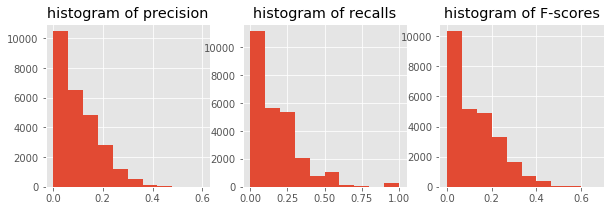

Average precision on cross validation set:  0.09264691577092868
Average recall on cross validation set:  0.1552812082699183
Average F-score on cross validation set:  0.11364571115758526


In [391]:
scores = [compute_scores(predicted_ing[i], remaining_ing[i]) for i in range(len(remaining_ing))]

precisions = [item[0] for item in scores] 
recalls = [item[1] for item in scores]
Fscores = [item[2] for item in scores]

fig, ax = plt.subplots(ncols = 3, figsize = (10,3))
ax[0].hist(precisions)
ax[0].set_title('histogram of precision')

ax[1].hist(recalls)
ax[1].set_title('histogram of recalls')

ax[2].hist(Fscores)
ax[2].set_title('histogram of F-scores')
plt.show()

print("Average precision on cross validation set: ", statistics.mean(precisions) )
print("Average recall on cross validation set: ", statistics.mean(recalls) )
print("Average F-score on cross validation set: ", statistics.mean(Fscores) )

<b> Make ingredient recommendations for CV set </b>

In [378]:
# get existing ingredients and the remaining ingredients to be predicted
sampled_ing, remaining_ing = sample_ingredients(ing_cv, 5)

# predict remaining ingredients
predicted_ing = recommend_ingredients_word2vec(model, sampled_ing, remaining_ing)

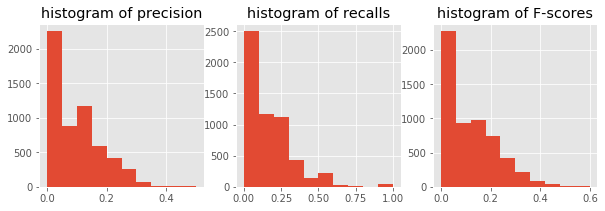

Average precision on cross validation set:  0.08902909831564408
Average recall on cross validation set:  0.1495653688075584
Average F-score on cross validation set:  0.10914539821476701


In [387]:
scores = [compute_scores(predicted_ing[i], remaining_ing[i]) for i in range(len(remaining_ing))]

precisions = [item[0] for item in scores] 
recalls = [item[1] for item in scores]
Fscores = [item[2] for item in scores]

fig, ax = plt.subplots(ncols = 3, figsize = (10,3))
ax[0].hist(precisions)
ax[0].set_title('histogram of precision')

ax[1].hist(recalls)
ax[1].set_title('histogram of recalls')

ax[2].hist(Fscores)
ax[2].set_title('histogram of F-scores')
plt.show()

print("Average precision on cross validation set: ", statistics.mean(precisions) )
print("Average recall on cross validation set: ", statistics.mean(recalls) )
print("Average F-score on cross validation set: ", statistics.mean(Fscores) )

# 5. Association rule mining

* Association rule mining is a tool used in market basket analysis that seeks relationships between purchases.  
* It finds rules of the form X => Y, which represents "X implies Y"
* For example, the rule {onions, potatoes} => {burger} found in the sales data would indicate that if a customer buys both onions and potatoes, then they are also likely to buy hamburger meat.  
* In this project, I used association rule mining to learn relationships among ingredients. For example, the rule {chicken, korean} => {seasame oil} would imply that if a recipe involves chicken and korean cuisine, then it is likely to also involve seasame oil as its ingredient. 
* Used Apriori algorithm to learn the rules.

## 4.1 Implement the apriori algorithm

* The apriori algorithm learns all rules of form X => Y where
    * X, Y are collections of items, called itemset.  
    * X and Y are itemsets with frequency (support) greater than min_support
    * The strength of the implication X => Y (as measured by confidence) is stronger than min_confidence  
* Apriori algorithm requires the user to specify minimum support of itemsets to consider and minimum confidence of the rules. 
* In this section, I played around with different minimum support and minimum confidence values and learned the rules among ingredients using the apriori algorithm.

In [305]:
df = pd.read_csv('data/ingredient_recommendation/data.csv')
cuisine = np.unique(df.cuisine)

# note: ing_cuisine is now a string representation of list
# need to convert back to list
ingredients = [ast.literal_eval(df.ing_cuisine[idx]) for idx in range(df.shape[0])]

# change data format to list of tuples for apriori algorithm 
ing_list = [tuple(item) for item in ingredients]

In [306]:
# get the list of ingredients
ingredients_total = [item for sublist in ing_list for item in sublist]

# count occurrence of ingredients
ing_count = Counter(ingredients_total)

# sort ingredients in order of decreasing frequency 
ing_by_count = [k for k, v in sorted(ing_count.items(), key = lambda item:item[1])]
ing_by_count.reverse()

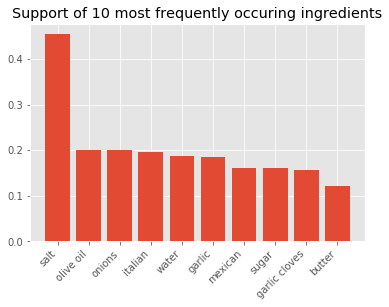

In [307]:
#plot the support of 10 most frequently occurring ingredients
plt.bar(ing_by_count[:10], [ing_count[item]/len(ing_list) for item in ing_by_count[:10]])
plt.xticks(list(range(10)), ing_by_count[:10], ha = 'right', rotation=45)
plt.title('Support of 10 most frequently occuring ingredients')
plt.show()

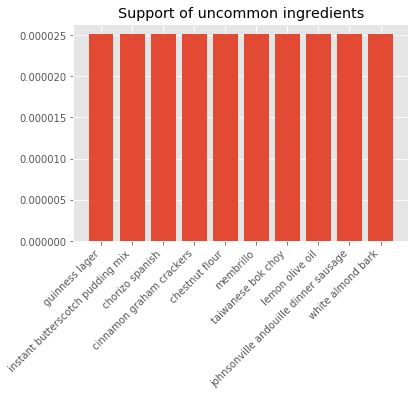

In [308]:
# plot the 10 most rarely occurring ingredients
# use support, instead of frequency 
plt.bar(ing_by_count[-10:], [ing_count[item]/len(ing_list) for item in ing_by_count[-10:]])
plt.xticks(list(range(10)), ing_by_count[-10:], ha = 'right', rotation=45)
plt.title('Support of uncommon ingredients')
plt.show()

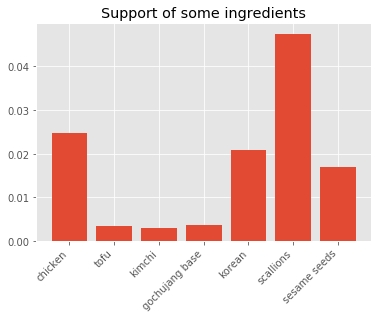

In [309]:
# support of ingredients that I think should be included
my_ingredients = ['chicken','tofu','kimchi', 'gochujang base', 'korean', 'scallions', 'sesame seeds']
plt.bar(my_ingredients, [ing_count[item]/len(ing_list) for item in my_ingredients])
plt.xticks(list(range(len(my_ingredients))), my_ingredients, ha = 'right', rotation=45)
plt.title('Support of some ingredients')
plt.show()

In [310]:
# what are some ingredients with a given support value?
support = 0.001
freq = support * len(ing_list)
ingredients_support = [item for item in ing_by_count if ing_count[item] <= freq + 10 and ing_count[item] >= freq -10 ]
print(ingredients_support[:20])

['organic vegetable broth', 'salad greens', 'file powder', 'rocket leaves', 'ground round', 'cod fillets', 'colby jack cheese', 'pitted date', 'tapioca flour', 'frozen spinach', 'green bell pepper, slice', 'plain whole-milk yogurt', 'duck', 'softened butter', 'low-fat plain yogurt', 'dried tarragon leaves', 'cooked turkey', 'alfredo sauce', 'brewed coffee', 'hot italian sausages']


In [311]:
# LEARNING THE RULES

itemsets, rules = apriori(ing_list, min_support=0.001, min_confidence=0.3)
with open("models/association_rule_mining/rules.txt", "wb") as fp:
    pickle.dump(rules, fp)

## 4.2 Query the rules 

In [312]:
# load the learned rules
with open("models/association_rule_mining/rules.txt", "rb") as fp:
    rules = pickle.load(fp)
    
print('number of rules learned: ', len(rules))

number of rules learned:  74470


In [313]:
def get_rules(rules, query):
    # Find all rules of the form "query" => ?

    # query must have the format ('ingredient1', ) or ('ingredient1','ingredient2', ... ,)
    # note that some rules will have multiple items in the right hand side. For simplicity, lets just
    # use rules that return one value 
    query_rules = [item for item in rules if set(item.lhs) == set(query)]

    # sorted ccording to decreasing lift values 
    query_rules = sorted(query_rules, key=lambda rule: rule.lift, reverse = True)
    return query_rules   

In [315]:
query = ('gochujang base',)
query_rules = get_rules(rules, query)
for item in query_rules:
    print(item)

{gochujang base} -> {korean, onions} (conf: 0.338, supp: 0.001, lift: 64.638, conv: 1.503)
{gochujang base} -> {korean, soy sauce} (conf: 0.556, supp: 0.002, lift: 51.822, conv: 2.230)
{gochujang base} -> {korean, sesame oil} (conf: 0.521, supp: 0.002, lift: 51.432, conv: 2.067)
{gochujang base} -> {garlic, korean} (conf: 0.373, supp: 0.001, lift: 48.994, conv: 1.583)
{gochujang base} -> {korean, sesame oil, soy sauce} (conf: 0.345, supp: 0.001, lift: 48.670, conv: 1.516)
{gochujang base} -> {green onions, korean} (conf: 0.352, supp: 0.001, lift: 47.798, conv: 1.532)
{gochujang base} -> {korean} (conf: 0.958, supp: 0.003, lift: 45.896, conv: 23.173)
{gochujang base} -> {sesame oil, soy sauce} (conf: 0.366, supp: 0.001, lift: 12.981, conv: 1.533)
{gochujang base} -> {sesame oil} (conf: 0.542, supp: 0.002, lift: 12.164, conv: 2.087)
{gochujang base} -> {soy sauce} (conf: 0.592, supp: 0.002, lift: 7.138, conv: 2.245)
{gochujang base} -> {green onions} (conf: 0.352, supp: 0.001, lift: 4.55

In [316]:
query = ('chicken','soy sauce')
query_rules = get_rules(rules, query)
for item in query_rules:
    print(item)

{chicken, soy sauce} -> {chinese} (conf: 0.372, supp: 0.001, lift: 5.534, conv: 1.485)
{chicken, soy sauce} -> {garlic} (conf: 0.405, supp: 0.001, lift: 2.182, conv: 1.369)
{chicken, soy sauce} -> {water} (conf: 0.331, supp: 0.001, lift: 1.763, conv: 1.214)
{chicken, soy sauce} -> {salt} (conf: 0.479, supp: 0.001, lift: 1.056, conv: 1.049)


## 4.3 Build a recommendation system

* Input a list of existing ingredients.  
* Recommender searches the learned rules to recommend ingredients, starting with the ingredient with highest lift.  
* If the input list of existing ingredient doesn't exist as an itemset in the learned rules (this happens if the given input does not have enough support in the training dataset), then look for the largest subset of the existing ingredients that do exist as an itemset in the rules. Recommend from this largest subset. 

In [317]:
def get_rules(rules, query, lift_threshold = 1):
    # Find all implication rules of the form "query" => RHS
    # such that (i) RHS is a single ingredient and 
    #           (ii) lift value is greater than lift_threshold

    # "query" format ('ingredient1', ) or ('ingredient1','ingredient2', ... ,)
    query = tuple(query)    
    
    # get all rules "query" => RHS satisfying the conditions above
    query_rules = [item for item in rules if set(item.lhs) == set(query) 
                   if item.lift > lift_threshold and len(item.rhs) == 1]

    # sort rules according to decreasing lift values 
    query_rules = sorted(query_rules, key=lambda rule: rule.lift, reverse = True)
    return query_rules   

def recommend(list_ing, list_old, cuisine, rules):  
    # Recommend ingredients to given list of ingredients.
    # Given a list, attempt to find the largest subset of "n" elements such that
    # the subset leads to a valid ingredient recommendataion. 
    # If such "n" is found, then try recommending ingredients 
    # for all "n"-element subset of list_ing
    
    """
    list_ing: current list of ingredients 
    list_old: List of ingredients (a subset of list_ing) that have previously
            been used to ask for ingredient recommentations. 
            For first round of recommendations, list_old = []
            We keep track of "list_old" so that we don't make duplicate
            recommendations.
    rules: rules learned from apriori algorithm
    """           

    rules_lhs = {item.lhs for item in rules}
    n = len(list_ing)
    current_list = list_ing.copy()
    new_ing = []

    itemset_found = False
    
    while itemset_found == False and n > 0:
        # find all itemsets of size n
        comb = combinations(list_ing, n)

        # check if any itemset of size n satifies the conditions
        # (i) itemset isnt' a subset of list_old  
        # (ii) itemset exists as a left hand side element in rules 
        for itemset in comb:
            if (set(itemset).issubset(set(list_old)) == False) and (itemset in rules_lhs):
 
                # check if the itemset leads to a new ingredient recommendation
                query_rules = get_rules(rules, itemset)
                recommendation = [item.rhs[0] for item in query_rules]
                for ing in recommendation:
                    # if there exists an ingredient that is new and is not a cuisine type
                    # then this itemset just contributed a valid recommendation
                    if (ing not in current_list) and (ing not in cuisine):
                        current_list.append(ing)
                        new_ing.append(ing)            
                        itemset_found = True

        n = n-1           
    return new_ing

def make_recommendations(list_ing, cuisine, rules):
    # Make recommendations by calling the function "recommend" repeatedly.
    # Stop making recommendations when there are a total of 15 ingredients 
    # or when the "recommend" function no longer suggests any recommendations
    # whichever comes first.

    list_old = []
    while len(list_ing) <= 15:
        new_ing = recommend(list_ing, list_old, cuisine, rules)
        list_old = list_ing.copy()
        list_ing += new_ing
        if new_ing == []:
            break
            
    return list_ing

In [318]:
# load the learned rules
with open("models/association_rule_mining/rules.txt", "rb") as fp:
    rules = pickle.load(fp)
    
print('number of rules learned: ', len(rules))

number of rules learned:  74470


In [323]:
# ask the recommender for ingredients!
list_ing = ['pork', 'korean']
rules_lhs = {item.lhs for item in rules}
make_recommendations(list_ing, cuisine, rules)

['pork',
 'korean',
 'soy sauce',
 'garlic',
 'onions',
 'salt',
 'sesame oil',
 'green onions',
 'sugar',
 'pepper',
 'olive oil',
 'water',
 'oil']

# 6. Latent Dirichlet Allocation

In [3]:
# load data
df = pd.read_csv('data/ingredient_recommendation/data.csv')
cuisine = np.unique(df.cuisine)

# note: ing_cuisine is now a string representation of list
# need to convert back to list
ingredients = [ast.literal_eval(df.ing_cuisine[idx]) for idx in range(df.shape[0])]


In [12]:
from gensim.models.ldamodel import LdaModel
from keras.preprocessing.text import Tokenizer

from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

Using TensorFlow backend.


In [40]:
ing_dictionary = Dictionary(ingredients)
corpus = [ing_dictionary.doc2bow(item) for item in ingredients]

In [155]:
# train LDA model 
lda = LdaModel(corpus, id2word = ing_dictionary, num_topics = 20)

In [158]:
lda.show_topics(num_topics = 20)

[(0,
  '0.056*"italian" + 0.049*"salt" + 0.044*"garlic_cloves" + 0.043*"olive_oil" + 0.032*"ground_black_pepper" + 0.028*"dry_white_wine" + 0.026*"extra-virgin_olive_oil" + 0.025*"flat_leaf_parsley" + 0.025*"cooking_spray" + 0.019*"french"'),
 (1,
  '0.059*"olive_oil" + 0.049*"salt" + 0.045*"italian" + 0.039*"greek" + 0.030*"garlic_cloves" + 0.027*"extra-virgin_olive_oil" + 0.023*"ground_black_pepper" + 0.021*"tomatoes" + 0.021*"purple_onion" + 0.018*"dried_oregano"'),
 (2,
  '0.147*"italian" + 0.063*"grated_parmesan_cheese" + 0.045*"olive_oil" + 0.031*"garlic" + 0.031*"salt" + 0.022*"butter" + 0.022*"parmesan_cheese" + 0.021*"extra-virgin_olive_oil" + 0.019*"coarse_salt" + 0.017*"mozzarella_cheese"'),
 (3,
  '0.047*"french" + 0.038*"salt" + 0.035*"fresh_lemon_juice" + 0.028*"butter" + 0.025*"dijon_mustard" + 0.024*"large_shrimp" + 0.022*"southern_us" + 0.022*"large_eggs" + 0.021*"ground_black_pepper" + 0.020*"cajun_creole"'),
 (4,
  '0.059*"mayonaise" + 0.031*"southern_us" + 0.020*"li

In [ ]:
# with 10 topics, they each correspond to a different type of cuisine, like 
# chinese, italian, ...,

In [ ]:
# finding the right number of topics?

In [127]:
from gensim.models import CoherenceModel

In [163]:
# compute coherence scores for LDA models of various topic numbers

topic_numbers = list(range(1,20))
coherence_scores = {}

for k in topic_numbers:
    # train LDA model 
    lda = LdaModel(corpus, id2word = ing_dictionary, num_topics = k)
    
    # compute average coherence 
    cm = CoherenceModel(model=lda, corpus=corpus, coherence='u_mass')
    coherence = cm.get_coherence() 
    coherence_scores[k]=coherence

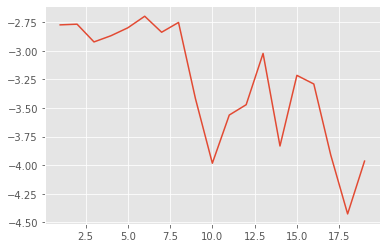

In [169]:
plt.plot(topic_numbers, [coherence_scores[item] for item in topic_numbers])
plt.show()

In [ ]:
# according to this internal metric, topic numbers of 6 or 8 would lead to
# highest coherence

In [113]:
def recommender_LDA(lda, ing_list, n_recommend, cuisine, ing_dictionary):
    # given a list of ingredients, recommend ingredients 
    # generated from trained LDAA
    
    """
    lda: learned LDA model
    ing_list: (list) of existing ingredients
    n_recommend: (int) number of ingredients to recommend
    cuisine: (list) of cuisine
    ing_dictionary: (dict) used to encode words for LDA model 
    """
    
    for i in range(n_recommend):
        # encode current list of ingredients
        current_recipe = ing_dictionary.doc2bow(ing_list)

        # get distribution of "topics"
        topics_vector = lda[current_recipe]  

        # sample "topic" for current recipe
        topics_list = [item[0] for item in topics_vector]
        topics_prob = [item[1] for item in topics_vector]
        topics_prob /= sum(topics_prob)
        topic = np.random.choice(topics_list, 1, p=topics_prob)[0]

        # get ingredients and their probabilities for sampled "topic"
        topic_words =  lda.show_topic(topic, topn = None)

        # remove cuisine type and current ingredients from words
        topic_words = [item for item in topic_words 
                   if (item[0] not in cuisine) 
                   and (item[0] not in current_ing)]

        # sample ingredients from these, according to the probabilities assigned
        words_prob = [item[1] for item in topic_words]
        words_prob /= sum(words_prob)

        ing_sampled = np.random.choice([item[0] for item in topic_words], 1, p=words_prob)[0]
        ing_list.append(ing_sampled)

    return ing_list



In [117]:
recommender_LDA(['chicken','gochujang_base'],4,cuisine,ing_dictionary)

['chicken',
 'gochujang_base',
 'rice_vinegar',
 'seasoning',
 'fresh_basil_leaves',
 'pepper']

In [170]:
# Using sklearn
from sklearn.decomposition import LatentDirichletAllocation


In [176]:
# tokenize
t=Tokenizer()  
t.fit_on_texts(ingredients)
encoded_recipes=t.texts_to_sequences(ingredients)

# create reverse dictionary from index to words 
index_to_words=dict(map(reversed,t.word_index.items())) 

# Prepare data matrix X
X = np.zeros((len(ingredients), len(t.word_index)))
for idx, item in enumerate(encoded_recipes):
    item = [x-1 for x in item]
    X[idx, item] = 1

In [179]:
lda = LatentDirichletAllocation(n_components = 10)
lda.fit(X)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=None,
                          topic_word_prior=None, total_samples=1000000.0,
                          verbose=0)

In [193]:
topics = lda.components_ / lda.components_.sum(axis=1)[:, np.newaxis]

In [210]:
# for each topic, print top 10 words
for topic in range(10):
    idx = np.argsort(topics[topic,:])[::-1][:10]
    print(topic, [index_to_words[item+1] for item in idx])


0 ['french', 'garlic_cloves', 'salt', 'olive_oil', 'extra-virgin_olive_oil', 'ground_black_pepper', 'fresh_lemon_juice', 'shallots', 'cooking_spray', 'dry_white_wine']
1 ['onions', 'cajun_creole', 'salt', 'garlic', 'green_bell_pepper', 'water', 'chicken_broth', 'celery', 'pepper', 'shrimp']
2 ['italian', 'olive_oil', 'salt', 'grated_parmesan_cheese', 'garlic', 'onions', 'garlic_cloves', 'ground_black_pepper', 'extra-virgin_olive_oil', 'pepper']
3 ['soy_sauce', 'chinese', 'sesame_oil', 'sugar', 'garlic', 'water', 'salt', 'green_onions', 'corn_starch', 'japanese']
4 ['salt', 'pepper', 'ground_black_pepper', 'greek', 'onions', 'paprika', 'olive_oil', 'garlic_powder', 'mayonaise', 'potatoes']
5 ['sugar', 'unsalted_butter', 'salt', 'all-purpose_flour', 'large_eggs', 'french', 'water', 'italian', 'vanilla_extract', 'granulated_sugar']
6 ['indian', 'salt', 'onions', 'ground_cumin', 'water', 'garam_masala', 'cumin_seed', 'ground_turmeric', 'garlic', 'moroccan']
7 ['thai', 'fish_sauce', 'coconu

In [215]:
# To find the number of topics:
# train LDA on various numbers of topics
# evaluate perplexity on CV set

# split into training and cv set
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(X, test_size = 0.3)

In [216]:
# compute coherence scores for LDA models of various topic numbers
topic_numbers = list(range(1,20))
scores = {}

for k in topic_numbers:
    # train LDA model 
    lda = LatentDirichletAllocation(n_components = k)
    lda.fit(X_train)
   
    # compute perplexity on X_test
    scores[k] = lda.perplexity(X_test)


KeyboardInterrupt: 

In [ ]:
plt.plot(topic_numbers, [scores[item] for item in topic_numbers])
plt.show()

# 7. Future directions / To Do

* Other models to consider  
    * max entropy model  
    
* To do for building recommender system  
    * Use evaluation metric to find the best model 
    * Or, combine the models using ensemble learning techniques  
    * Try using cloud computing
    * Create the app  
    * Use Docker containment for production  
    